<a href="https://colab.research.google.com/github/paulrobustelli/CHEM101.6/blob/main/Butane_OpenMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations of Alkanes using the OpenMM engine 

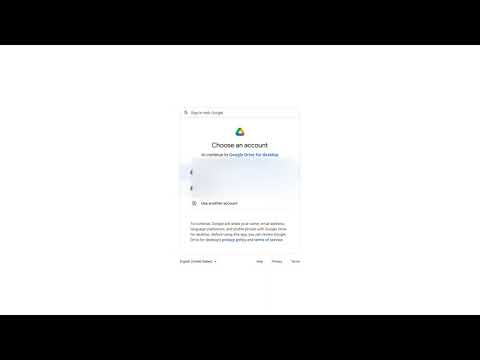

In [1]:
#@title ### **Video Demonstration**
#@markdown Check the timelapse movie to understand how the pipeline works
from IPython.display import YouTubeVideo
YouTubeVideo('pVa0mQS6xeo', width=800, height=500)

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)

In [2]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null
# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm Miniconda3-latest-Linux-x86_64.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null
#load dependencies
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
from __future__ import print_function
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
#%matplotlib inline
#set_matplotlib_formats('png')
#plt.figure(figsize=(5,7))

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [13]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Nov 30 22:01:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
from simtk import unit
from openmm import app

#Lets Load in our Butane Molecule and Force Field from Our Google Drive
PDB_file_name = 'butane.pdb'
forcefield_file_name = 'butane.gaff2.xml' 
Google_Drive_Path = '/content/drive/MyDrive/CHEM101.6/Butane' #@param {type:"string"}
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(PDB_file_name))
force_field = os.path.join(workDir,str(forcefield_file_name))
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/content/drive/MyDrive/CHEM101.6/Butane/butane.pdb
/content/drive/MyDrive/CHEM101.6/Butane/butane.gaff2.xml


In [47]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.295784483017471 kJ/mol
Potential energy after minimization is 5.295543508947829 kJ/mol


In [49]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,30.141760285407493,262.9486052648526
200,33.8926801562416,348.09445655702
300,55.994071653301404,366.0136405419244
400,54.24842375179601,289.0307002468811
500,45.2128663417995,365.3051316316242
600,35.19999667321129,233.8858661398986
700,26.67592490128446,340.5430402157909
800,34.784536338777116,252.83953584933127
900,30.047732377737628,173.8565592390809
1000,30.07483289279336,153.08152399988532
1100,26.858483853709018,254.63734211014173
1200,27.910438613634035,352.15652735892314
1300,47.71719988112596,171.70074006044825
1400,39.81715231859009,329.2049804597984
1500,45.99278999223017,273.9888698425713
1600,25.956957762751934,321.19901601528915
1700,32.68588828305849,268.7648764009242
1800,34.12331521932133,389.27416786415273
1900,31.00992473575137,271.2848279052134
2000,27.340059260451387,310.7694303574131
2100,40.6453010605359,336.72624429166484
2200,40.39859482956306,289.1053896058646
2300,31.508056076957637,

In [50]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('ethane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,39.511268730648524,317.384018666217,0
500000,999.9999999901769,29.694501452629122,275.92529600473466,1.22e+04
750000,1499.9999999783536,44.28588525491841,350.07384580167127,1.21e+04
1000000,1999.9999999665301,37.28139867077346,287.0072359586417,1.21e+04
1250000,2499.9999999547067,44.30333309964481,530.6915535111848,1.2e+04
1500000,2999.9999999428833,32.833865583669855,338.00543482360206,1.2e+04
1750000,3499.99999993106,47.87336295615768,347.88334359928496,1.2e+04
2000000,3999.9999999192364,47.76379073855511,299.2020084130648,1.2e+04
2250000,4499.9999999992715,62.58231665991362,309.9144192727793,1.2e+04
2500000,5000.000000101135,34.40396058013606,232.95465784728395,1.2e+04
2750000,5500.000000202998,45.63810515555039,272.25260931691014,1.2e+04
3000000,6000.000000304862,58.92993416468104,256.1436970220182,1.2e+04
3250000,6500.000000406725,37.18736517107332,263

In [52]:
!pip install nglview 2>&1 1>/dev/null
!conda install -c conda-forge mdtraj  --yes 2>&1 1>/dev/null

In [55]:
import mdtraj as md
traj = md.load('ethane_sim.dcd', top=initial_pdb)


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x7fea7880b8d0>

In [58]:
import ipywidgets
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')
from google.colab import output
output.enable_custom_widget_manager()

import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

In [59]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


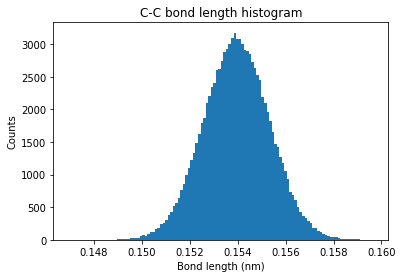

In [70]:
bond_indices = [4, 7] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

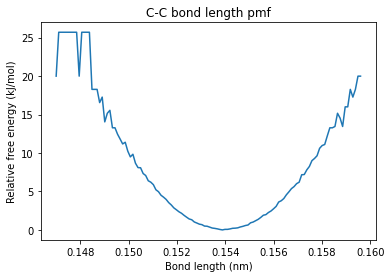

In [72]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
bondcounts[bondcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(bondcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

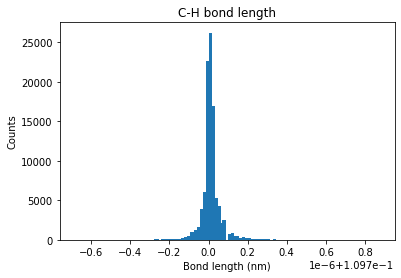

In [78]:
bond_indices = [4, 5] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

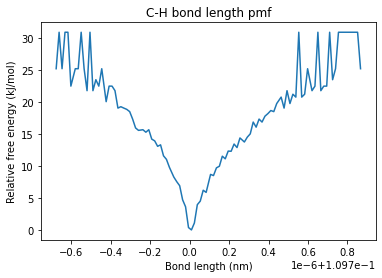

In [79]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
lengthcounts[lengthcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(lengthcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-H bond length pmf')
plt.show()

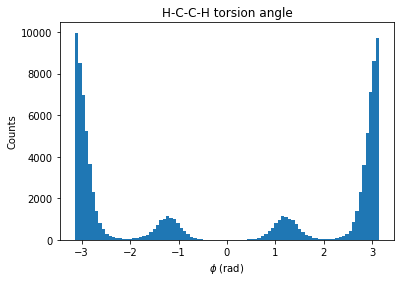

In [63]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

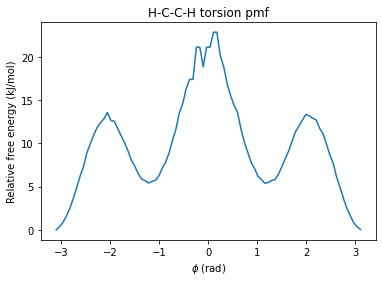

In [64]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

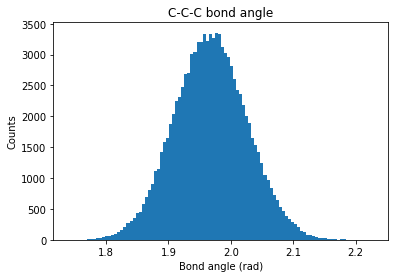

In [66]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

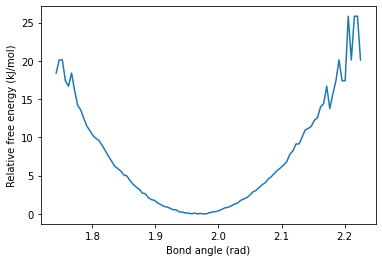

In [67]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()